In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import os
from itertools import cycle

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import RobustScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

import optuna

c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pwd = os.getcwd()
pwd

'd:\\Research Projects\\HEA\\Featurize_New_Alloys\\HEA'

In [4]:
df = pd.read_csv(pwd+"/raw_dataset/HEA_tr_NETCORE.csv")
print("Shape of Dataframe: ", df.shape)
df.head()

Shape of Dataframe:  (1167, 44)


,Alloy,avg_dev_AtomicWeight,maximum_MeltingT,avg_dev_MeltingT,mode_MeltingT,avg_dev_Column,mean_Row,mode_Row,minimum_CovalentRadius,maximum_CovalentRadius,range_CovalentRadius,avg_dev_CovalentRadius,mode_CovalentRadius,maximum_Electronegativity,mean_Electronegativity,mode_Electronegativity,mean_NsValence,maximum_NpValence,mean_NpValence,avg_dev_NpValence,range_NdValence,mean_NdValence,avg_dev_NdValence,avg_dev_NValence,mode_NValence,maximum_NdUnfilled,range_NdUnfilled,avg_dev_NdUnfilled,mode_NUnfilled,minimum_GSvolume_pa,range_GSvolume_pa,mode_GSvolume_pa,maximum_GSbandgap,avg_dev_GSbandgap,range_GSmagmom,minimum_SpaceGroupNumber,maximum_SpaceGroupNumber,mean_SpaceGroupNumber,range_Column,maximum_NpUnfilled,maximum_NdValence,mode_MendeleevNumber,range_NUnfilled,Phase
0,Al0.5NbTaTiV,3.838070,3290.0,584.546173,7.571474,0.966843,4.555556,4,121,170,3.912023,2.391138,153,1.63,1.572222,0.916291,1.777778,0.693147,0.111111,0.180262,4,2.666667,0.635989,1.797913,1.609438,8,8,0.908856,7,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,220.777778,9,5,4,43,3,BCC
1,Al0.75MoNbTiV,3.255577,2896.0,521.067701,7.571474,1.140210,4.263158,4,121,164,3.784190,2.377029,153,2.16,1.713158,0.932164,1.578947,0.693147,0.157895,0.235805,5,2.947368,0.845714,0.598806,1.609438,8,8,1.074312,6,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,221.000000,9,5,5,43,3,BCC
2,Al0.25MoNbTiV,3.205911,2896.0,441.662561,7.571474,0.758442,4.411765,4,121,164,3.784190,1.950841,153,2.16,1.725294,0.932164,1.529412,0.693147,0.058824,0.105014,5,3.294118,0.758442,0.492669,1.609438,8,8,0.833360,6,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,220.529412,9,5,5,43,3,BCC
3,Al0.25NbTaTiV,3.825406,3290.0,539.821730,7.571474,0.648931,4.647059,4,121,170,3.912023,2.140270,153,1.63,1.570000,0.916291,1.764706,0.693147,0.058824,0.105014,4,2.823529,0.542163,1.825219,1.609438,8,8,0.718768,7,2.639771,1.819699,2.639771,0.0,0.0,0.000023,194,229,220.529412,9,5,4,43,3,BCC
4,Al0.2MoTaTiV,3.838178,3290.0,565.511565,7.571474,0.703300,4.666667,4,121,170,3.912023,2.105461,153,2.16,1.702857,0.916291,1.761905,0.693147,0.047619,0.086822,5,3.095238,0.645547,1.812332,1.609438,8,8,0.829650,6,2.639771,1.809927,2.639771,0.0,0.0,0.000023,194,229,220.476191,9,5,5,43,3,BCC


In [5]:
# SHUFFLE THE DATASET
df = df.sample(frac=1, random_state=42)
X = df.copy().drop(columns=["Alloy", "Phase"])
y = df["Phase"].astype("category")
print(f"Shape of feature: {X.shape}\nShape of labels: {y.shape}")

Shape of feature: (1167, 42)
Shape of labels: (1167,)


In [6]:
# check class imbalance
print(y.value_counts(ascending=False))

Phase
MIP        428
BCC        363
FCC        211
FCC_BCC    165
Name: count, dtype: int64


In [7]:
from imblearn.over_sampling import SMOTE
X, y = SMOTE(random_state=42).fit_resample(X, y)
print(f"Shape of feature: {X.shape}\nShape of labels: {y.shape}")

c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\shoha\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Shape of feature: (1712, 42)
Shape of labels: (1712,)


In [8]:
# check for class imbalance
print(y.value_counts(ascending=False))

Phase
BCC        428
FCC        428
FCC_BCC    428
MIP        428
Name: count, dtype: int64


In [9]:
# SCALE FEATURES
X = pd.DataFrame(RobustScaler().fit_transform(X), columns=X.columns)
X.head()

,avg_dev_AtomicWeight,maximum_MeltingT,avg_dev_MeltingT,mode_MeltingT,avg_dev_Column,mean_Row,mode_Row,minimum_CovalentRadius,maximum_CovalentRadius,range_CovalentRadius,avg_dev_CovalentRadius,mode_CovalentRadius,maximum_Electronegativity,mean_Electronegativity,mode_Electronegativity,mean_NsValence,maximum_NpValence,mean_NpValence,avg_dev_NpValence,range_NdValence,mean_NdValence,avg_dev_NdValence,avg_dev_NValence,mode_NValence,maximum_NdUnfilled,range_NdUnfilled,avg_dev_NdUnfilled,mode_NUnfilled,minimum_GSvolume_pa,range_GSvolume_pa,mode_GSvolume_pa,maximum_GSbandgap,avg_dev_GSbandgap,range_GSmagmom,minimum_SpaceGroupNumber,maximum_SpaceGroupNumber,mean_SpaceGroupNumber,range_Column,maximum_NpUnfilled,maximum_NdValence,mode_MendeleevNumber,range_NUnfilled
0,0.161097,1.256140,0.606754,0.532601,0.521256,-0.216360,0.0,0.0,0.18,0.584759,0.717467,1.363636,0.25,0.232362,0.449317,-1.196825,0.000000,0.477222,0.422557,0.000000,-0.304043,0.175303,-0.008391,0.000000,0.000000,0.0,0.190333,1.333333,0.000000,0.000000,0.336801,0.000,0.000000,0.0,0.0,0.0,0.640823,0.000000,0.0,0.0,0.000000,0.0
1,-0.709468,-0.647368,-0.538152,-0.471801,-0.863198,0.220453,0.0,1.0,-0.42,-0.427776,-1.279471,0.000000,0.05,1.471545,1.916202,-0.110975,0.584963,-0.223215,-0.254527,-0.666667,1.487024,-0.236945,-0.963679,0.560099,-0.333333,-0.5,-0.196263,-0.333333,0.000000,10.948033,-0.030237,0.000,0.000000,0.0,-53.0,0.0,-0.640578,-0.333333,-0.2,1.0,0.666667,-1.0
2,-0.551801,-0.647368,-0.934202,0.039657,-0.977210,-0.216360,0.0,0.0,-0.70,-0.814217,-1.599888,0.000000,0.00,1.090976,1.916202,1.809577,0.000000,0.026149,0.020301,0.000000,0.584874,-0.225051,-0.802636,0.560099,-0.333333,-0.5,-0.853525,0.000000,0.000000,0.000000,-0.030237,0.000,0.000000,0.0,0.0,0.0,-0.694305,-0.666667,0.0,0.0,0.666667,-1.0
3,0.428073,2.882456,0.969928,-1.266392,0.594814,-1.406341,-1.0,-15.0,-0.42,1.434420,1.058207,-0.272727,0.64,0.850365,0.000000,0.362050,0.584963,1.529725,1.115875,0.000000,-0.534503,0.775456,0.299071,-1.247204,0.000000,0.0,0.262099,0.000000,-79.249736,4.490789,-0.030237,4.496,0.616735,0.0,0.0,0.0,-0.283342,0.333333,0.0,0.0,0.000000,0.0
4,0.071655,1.256140,0.363886,0.039657,0.103571,0.140634,0.0,0.0,0.18,0.584759,0.646848,0.000000,0.25,0.820978,0.449317,-0.535416,0.000000,0.161471,0.153797,0.000000,0.067211,0.047385,-0.120768,0.000000,0.000000,0.0,-0.141745,0.000000,0.000000,0.000000,-0.030237,0.000,0.000000,0.0,0.0,0.0,0.269152,0.000000,0.0,0.0,0.000000,0.0


In [10]:
# Label encode y and then to_categorical
lb_enc = LabelEncoder()
y = lb_enc.fit_transform(y)

In [11]:
labels = list(lb_enc.classes_)
labels

['BCC', 'FCC', 'FCC_BCC', 'MIP']

In [12]:
print(dict(zip(lb_enc.inverse_transform([0, 1, 2, 3]), [0, 1, 2, 3])))

{'BCC': 0, 'FCC': 1, 'FCC_BCC': 2, 'MIP': 3}


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape of training features: {X_train.shape}")
print(f"Shape of training labels: {y_train.shape}")
print(f"Shape of test features: {X_test.shape}")
print(f"Shape of test labels: {y_test.shape}")

Shape of training features: (1369, 42)
Shape of training labels: (1369,)
Shape of test features: (343, 42)
Shape of test labels: (343,)


In [14]:
# DEFINE OBJECTIVE FUNCTION
def obj_fn(trial):
    # DEFINE PARAMETER SPACE
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
        "max_depth":    trial.suggest_int("max_depth", 3, 10),
        "criterion": trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss']),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 5, 50, step=5),
        "max_features": trial.suggest_categorical("max_features", ['sqrt', 'log2'])
    }
    # CONSTRUCT MODEL
    model = ExtraTreesClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)

    return test_acc

In [15]:
# PERFORM BAYESIAN OPTIMIZATION
tpe = optuna.samplers.TPESampler()
study = optuna.create_study(direction="maximize", sampler=tpe)
study.optimize(obj_fn, n_trials=50, show_progress_bar=True)

[I 2024-10-01 04:21:43,599] A new study created in memory with name: no-name-6bcd5531-350b-49ce-a1c4-16d25dc38d7a
Best trial: 0. Best value: 0.61516:   2%|▏         | 1/50 [00:00<00:13,  3.77it/s]

[I 2024-10-01 04:21:43,865] Trial 0 finished with value: 0.6151603498542274 and parameters: {'n_estimators': 50, 'max_depth': 3, 'criterion': 'gini', 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_leaf_nodes': 40, 'max_features': 'log2'}. Best is trial 0 with value: 0.6151603498542274.


Best trial: 0. Best value: 0.61516:   4%|▍         | 2/50 [00:02<01:02,  1.30s/it]

[I 2024-10-01 04:21:45,885] Trial 1 finished with value: 0.6151603498542274 and parameters: {'n_estimators': 400, 'max_depth': 3, 'criterion': 'gini', 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_leaf_nodes': 45, 'max_features': 'log2'}. Best is trial 0 with value: 0.6151603498542274.


Best trial: 2. Best value: 0.760933:   6%|▌         | 3/50 [00:03<00:53,  1.14s/it]

[I 2024-10-01 04:21:46,824] Trial 2 finished with value: 0.760932944606414 and parameters: {'n_estimators': 150, 'max_depth': 9, 'criterion': 'gini', 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_leaf_nodes': 45, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.760932944606414.


Best trial: 2. Best value: 0.760933:   8%|▊         | 4/50 [00:04<00:51,  1.12s/it]

[I 2024-10-01 04:21:47,915] Trial 3 finished with value: 0.6443148688046647 and parameters: {'n_estimators': 250, 'max_depth': 4, 'criterion': 'log_loss', 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_leaf_nodes': 20, 'max_features': 'log2'}. Best is trial 2 with value: 0.760932944606414.


Best trial: 2. Best value: 0.760933:  10%|█         | 5/50 [00:05<00:56,  1.25s/it]

[I 2024-10-01 04:21:49,407] Trial 4 finished with value: 0.749271137026239 and parameters: {'n_estimators': 450, 'max_depth': 8, 'criterion': 'entropy', 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_leaf_nodes': 40, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.760932944606414.


Best trial: 2. Best value: 0.760933:  12%|█▏        | 6/50 [00:06<00:43,  1.00it/s]

[I 2024-10-01 04:21:49,911] Trial 5 finished with value: 0.7026239067055393 and parameters: {'n_estimators': 100, 'max_depth': 6, 'criterion': 'entropy', 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_leaf_nodes': 20, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.760932944606414.


Best trial: 2. Best value: 0.760933:  14%|█▍        | 7/50 [00:07<00:42,  1.01it/s]

[I 2024-10-01 04:21:50,889] Trial 6 finished with value: 0.7142857142857143 and parameters: {'n_estimators': 200, 'max_depth': 8, 'criterion': 'gini', 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_leaf_nodes': 20, 'max_features': 'log2'}. Best is trial 2 with value: 0.760932944606414.


Best trial: 2. Best value: 0.760933:  16%|█▌        | 8/50 [00:09<00:56,  1.34s/it]

[I 2024-10-01 04:21:52,984] Trial 7 finished with value: 0.6967930029154519 and parameters: {'n_estimators': 400, 'max_depth': 5, 'criterion': 'entropy', 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_leaf_nodes': 50, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.760932944606414.


Best trial: 2. Best value: 0.760933:  18%|█▊        | 9/50 [00:10<00:53,  1.30s/it]

[I 2024-10-01 04:21:54,174] Trial 8 finished with value: 0.7317784256559767 and parameters: {'n_estimators': 200, 'max_depth': 9, 'criterion': 'gini', 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_leaf_nodes': 25, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.760932944606414.


Best trial: 2. Best value: 0.760933:  20%|██        | 10/50 [00:12<00:58,  1.46s/it]

[I 2024-10-01 04:21:56,011] Trial 9 finished with value: 0.6530612244897959 and parameters: {'n_estimators': 350, 'max_depth': 4, 'criterion': 'entropy', 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_leaf_nodes': 25, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.760932944606414.


Best trial: 2. Best value: 0.760933:  22%|██▏       | 11/50 [00:13<00:52,  1.35s/it]

[I 2024-10-01 04:21:57,121] Trial 10 finished with value: 0.5830903790087464 and parameters: {'n_estimators': 150, 'max_depth': 10, 'criterion': 'log_loss', 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_leaf_nodes': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.760932944606414.


Best trial: 2. Best value: 0.760933:  24%|██▍       | 12/50 [00:16<01:14,  1.97s/it]

[I 2024-10-01 04:22:00,504] Trial 11 finished with value: 0.749271137026239 and parameters: {'n_estimators': 500, 'max_depth': 8, 'criterion': 'entropy', 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_leaf_nodes': 35, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.760932944606414.


Best trial: 2. Best value: 0.760933:  26%|██▌       | 13/50 [00:20<01:27,  2.38s/it]

[I 2024-10-01 04:22:03,798] Trial 12 finished with value: 0.7317784256559767 and parameters: {'n_estimators': 500, 'max_depth': 7, 'criterion': 'gini', 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_leaf_nodes': 35, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.760932944606414.


Best trial: 13. Best value: 0.77551:  28%|██▊       | 14/50 [00:22<01:25,  2.37s/it]

[I 2024-10-01 04:22:06,155] Trial 13 finished with value: 0.7755102040816326 and parameters: {'n_estimators': 300, 'max_depth': 10, 'criterion': 'entropy', 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_leaf_nodes': 50, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.7755102040816326.


Best trial: 14. Best value: 0.778426:  30%|███       | 15/50 [00:24<01:20,  2.30s/it]

[I 2024-10-01 04:22:08,319] Trial 14 finished with value: 0.7784256559766763 and parameters: {'n_estimators': 300, 'max_depth': 10, 'criterion': 'log_loss', 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_leaf_nodes': 50, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7784256559766763.


Best trial: 14. Best value: 0.778426:  32%|███▏      | 16/50 [00:26<01:13,  2.16s/it]

[I 2024-10-01 04:22:10,144] Trial 15 finished with value: 0.7784256559766763 and parameters: {'n_estimators': 300, 'max_depth': 10, 'criterion': 'log_loss', 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_leaf_nodes': 50, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7784256559766763.


Best trial: 14. Best value: 0.778426:  34%|███▍      | 17/50 [00:27<01:03,  1.92s/it]

[I 2024-10-01 04:22:11,498] Trial 16 finished with value: 0.5830903790087464 and parameters: {'n_estimators': 300, 'max_depth': 10, 'criterion': 'log_loss', 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_leaf_nodes': 5, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7784256559766763.


Best trial: 14. Best value: 0.778426:  36%|███▌      | 18/50 [00:30<01:07,  2.10s/it]

[I 2024-10-01 04:22:14,019] Trial 17 finished with value: 0.7696793002915452 and parameters: {'n_estimators': 350, 'max_depth': 9, 'criterion': 'log_loss', 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_leaf_nodes': 50, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7784256559766763.


Best trial: 14. Best value: 0.778426:  38%|███▊      | 19/50 [00:31<00:59,  1.93s/it]

[I 2024-10-01 04:22:15,551] Trial 18 finished with value: 0.7376093294460642 and parameters: {'n_estimators': 250, 'max_depth': 7, 'criterion': 'log_loss', 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_leaf_nodes': 35, 'max_features': 'log2'}. Best is trial 14 with value: 0.7784256559766763.


Best trial: 14. Best value: 0.778426:  40%|████      | 20/50 [00:33<00:57,  1.92s/it]

[I 2024-10-01 04:22:17,443] Trial 19 finished with value: 0.7784256559766763 and parameters: {'n_estimators': 350, 'max_depth': 10, 'criterion': 'log_loss', 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_leaf_nodes': 45, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7784256559766763.


Best trial: 14. Best value: 0.778426:  42%|████▏     | 21/50 [00:35<00:50,  1.75s/it]

[I 2024-10-01 04:22:18,779] Trial 20 finished with value: 0.7230320699708455 and parameters: {'n_estimators': 200, 'max_depth': 6, 'criterion': 'log_loss', 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_leaf_nodes': 30, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7784256559766763.


Best trial: 14. Best value: 0.778426:  44%|████▍     | 22/50 [00:37<00:54,  1.93s/it]

[I 2024-10-01 04:22:21,158] Trial 21 finished with value: 0.7784256559766763 and parameters: {'n_estimators': 350, 'max_depth': 10, 'criterion': 'log_loss', 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_leaf_nodes': 45, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7784256559766763.


Best trial: 14. Best value: 0.778426:  46%|████▌     | 23/50 [00:39<00:51,  1.92s/it]

[I 2024-10-01 04:22:23,057] Trial 22 finished with value: 0.7725947521865889 and parameters: {'n_estimators': 300, 'max_depth': 9, 'criterion': 'log_loss', 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_leaf_nodes': 50, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7784256559766763.


Best trial: 14. Best value: 0.778426:  48%|████▊     | 24/50 [00:42<00:56,  2.16s/it]

[I 2024-10-01 04:22:25,772] Trial 23 finished with value: 0.7638483965014577 and parameters: {'n_estimators': 400, 'max_depth': 10, 'criterion': 'log_loss', 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_leaf_nodes': 40, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7784256559766763.


Best trial: 14. Best value: 0.778426:  50%|█████     | 25/50 [00:44<00:54,  2.20s/it]

[I 2024-10-01 04:22:28,041] Trial 24 finished with value: 0.7638483965014577 and parameters: {'n_estimators': 350, 'max_depth': 9, 'criterion': 'log_loss', 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_leaf_nodes': 45, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7784256559766763.


Best trial: 14. Best value: 0.778426:  52%|█████▏    | 26/50 [00:45<00:46,  1.95s/it]

[I 2024-10-01 04:22:29,429] Trial 25 finished with value: 0.7551020408163265 and parameters: {'n_estimators': 250, 'max_depth': 8, 'criterion': 'log_loss', 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_leaf_nodes': 50, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7784256559766763.


Best trial: 14. Best value: 0.778426:  54%|█████▍    | 27/50 [00:47<00:45,  1.97s/it]

[I 2024-10-01 04:22:31,443] Trial 26 finished with value: 0.7667638483965015 and parameters: {'n_estimators': 450, 'max_depth': 10, 'criterion': 'log_loss', 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': 45, 'max_features': 'log2'}. Best is trial 14 with value: 0.7784256559766763.


Best trial: 14. Best value: 0.778426:  56%|█████▌    | 28/50 [00:49<00:40,  1.83s/it]

[I 2024-10-01 04:22:32,963] Trial 27 finished with value: 0.7638483965014577 and parameters: {'n_estimators': 300, 'max_depth': 9, 'criterion': 'log_loss', 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_leaf_nodes': 40, 'max_features': 'sqrt'}. Best is trial 14 with value: 0.7784256559766763.


Best trial: 28. Best value: 0.781341:  58%|█████▊    | 29/50 [00:52<00:44,  2.14s/it]

[I 2024-10-01 04:22:35,814] Trial 28 finished with value: 0.7813411078717201 and parameters: {'n_estimators': 400, 'max_depth': 10, 'criterion': 'log_loss', 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_leaf_nodes': 50, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  60%|██████    | 30/50 [00:52<00:32,  1.61s/it]

[I 2024-10-01 04:22:36,187] Trial 29 finished with value: 0.6647230320699709 and parameters: {'n_estimators': 50, 'max_depth': 7, 'criterion': 'log_loss', 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_leaf_nodes': 10, 'max_features': 'log2'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  62%|██████▏   | 31/50 [00:55<00:37,  1.97s/it]

[I 2024-10-01 04:22:39,006] Trial 30 finished with value: 0.7521865889212828 and parameters: {'n_estimators': 450, 'max_depth': 8, 'criterion': 'log_loss', 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_leaf_nodes': 40, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  64%|██████▍   | 32/50 [00:58<00:39,  2.17s/it]

[I 2024-10-01 04:22:41,637] Trial 31 finished with value: 0.7813411078717201 and parameters: {'n_estimators': 400, 'max_depth': 10, 'criterion': 'log_loss', 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_leaf_nodes': 50, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  66%|██████▌   | 33/50 [01:00<00:40,  2.39s/it]

[I 2024-10-01 04:22:44,555] Trial 32 finished with value: 0.7725947521865889 and parameters: {'n_estimators': 400, 'max_depth': 10, 'criterion': 'log_loss', 'min_samples_split': 3, 'min_samples_leaf': 8, 'max_leaf_nodes': 50, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  68%|██████▊   | 34/50 [01:03<00:39,  2.48s/it]

[I 2024-10-01 04:22:47,235] Trial 33 finished with value: 0.760932944606414 and parameters: {'n_estimators': 400, 'max_depth': 9, 'criterion': 'log_loss', 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_leaf_nodes': 45, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  70%|███████   | 35/50 [01:06<00:38,  2.54s/it]

[I 2024-10-01 04:22:49,902] Trial 34 finished with value: 0.7667638483965015 and parameters: {'n_estimators': 450, 'max_depth': 10, 'criterion': 'log_loss', 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_leaf_nodes': 50, 'max_features': 'log2'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  72%|███████▏  | 36/50 [01:08<00:34,  2.47s/it]

[I 2024-10-01 04:22:52,216] Trial 35 finished with value: 0.7580174927113703 and parameters: {'n_estimators': 400, 'max_depth': 9, 'criterion': 'gini', 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_leaf_nodes': 45, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  74%|███████▍  | 37/50 [01:09<00:26,  2.07s/it]

[I 2024-10-01 04:22:53,363] Trial 36 finished with value: 0.6005830903790087 and parameters: {'n_estimators': 250, 'max_depth': 3, 'criterion': 'log_loss', 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_leaf_nodes': 45, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  76%|███████▌  | 38/50 [01:11<00:24,  2.01s/it]

[I 2024-10-01 04:22:55,240] Trial 37 finished with value: 0.7638483965014577 and parameters: {'n_estimators': 300, 'max_depth': 9, 'criterion': 'log_loss', 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_leaf_nodes': 50, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  78%|███████▊  | 39/50 [01:14<00:23,  2.15s/it]

[I 2024-10-01 04:22:57,701] Trial 38 finished with value: 0.760932944606414 and parameters: {'n_estimators': 450, 'max_depth': 10, 'criterion': 'log_loss', 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_leaf_nodes': 40, 'max_features': 'log2'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  80%|████████  | 40/50 [01:16<00:21,  2.18s/it]

[I 2024-10-01 04:22:59,952] Trial 39 finished with value: 0.7376093294460642 and parameters: {'n_estimators': 350, 'max_depth': 8, 'criterion': 'gini', 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_leaf_nodes': 30, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  82%|████████▏ | 41/50 [01:18<00:18,  2.03s/it]

[I 2024-10-01 04:23:01,625] Trial 40 finished with value: 0.7113702623906706 and parameters: {'n_estimators': 250, 'max_depth': 9, 'criterion': 'log_loss', 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_leaf_nodes': 15, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  84%|████████▍ | 42/50 [01:19<00:16,  2.00s/it]

[I 2024-10-01 04:23:03,580] Trial 41 finished with value: 0.7784256559766763 and parameters: {'n_estimators': 350, 'max_depth': 10, 'criterion': 'log_loss', 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_leaf_nodes': 45, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  86%|████████▌ | 43/50 [01:21<00:13,  1.99s/it]

[I 2024-10-01 04:23:05,559] Trial 42 finished with value: 0.7784256559766763 and parameters: {'n_estimators': 350, 'max_depth': 10, 'criterion': 'log_loss', 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_leaf_nodes': 50, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  88%|████████▊ | 44/50 [01:24<00:12,  2.06s/it]

[I 2024-10-01 04:23:07,762] Trial 43 finished with value: 0.7784256559766763 and parameters: {'n_estimators': 400, 'max_depth': 10, 'criterion': 'log_loss', 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_leaf_nodes': 45, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  90%|█████████ | 45/50 [01:25<00:09,  1.96s/it]

[I 2024-10-01 04:23:09,481] Trial 44 finished with value: 0.7638483965014577 and parameters: {'n_estimators': 300, 'max_depth': 9, 'criterion': 'entropy', 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_leaf_nodes': 50, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  92%|█████████▏| 46/50 [01:28<00:08,  2.04s/it]

[I 2024-10-01 04:23:11,707] Trial 45 finished with value: 0.6938775510204082 and parameters: {'n_estimators': 400, 'max_depth': 5, 'criterion': 'log_loss', 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_leaf_nodes': 45, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  94%|█████████▍| 47/50 [01:30<00:06,  2.08s/it]

[I 2024-10-01 04:23:13,870] Trial 46 finished with value: 0.7638483965014577 and parameters: {'n_estimators': 350, 'max_depth': 10, 'criterion': 'gini', 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_leaf_nodes': 50, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  96%|█████████▌| 48/50 [01:31<00:03,  1.82s/it]

[I 2024-10-01 04:23:15,085] Trial 47 finished with value: 0.7521865889212828 and parameters: {'n_estimators': 200, 'max_depth': 8, 'criterion': 'entropy', 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_leaf_nodes': 40, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341:  98%|█████████▊| 49/50 [01:35<00:02,  2.36s/it]

[I 2024-10-01 04:23:18,720] Trial 48 finished with value: 0.760932944606414 and parameters: {'n_estimators': 500, 'max_depth': 10, 'criterion': 'log_loss', 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_leaf_nodes': 35, 'max_features': 'sqrt'}. Best is trial 28 with value: 0.7813411078717201.


Best trial: 28. Best value: 0.781341: 100%|██████████| 50/50 [01:37<00:00,  1.94s/it]

[I 2024-10-01 04:23:20,643] Trial 49 finished with value: 0.7638483965014577 and parameters: {'n_estimators': 300, 'max_depth': 9, 'criterion': 'log_loss', 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_leaf_nodes': 50, 'max_features': 'log2'}. Best is trial 28 with value: 0.7813411078717201.


In [16]:
best_model_params = study.best_params
best_model_params

{'n_estimators': 400,
 'max_depth': 10,
 'criterion': 'log_loss',
 'min_samples_split': 2,
 'min_samples_leaf': 7,
 'max_leaf_nodes': 50,
 'max_features': 'sqrt'}

In [17]:
# BUILD MODEL USING BEST PARAMETERS AND EVALUATE
best_model = ExtraTreesClassifier(**best_model_params, random_state=42)
best_model.fit(X_train, y_train)
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# CLASSIFICATION REPORT
print("Classification Report on Training Data")
print("-"*80)
print(classification_report(y_train, y_train_pred, target_names=labels, digits=4))

print("Classification Report on Test Data")
print("-"*80)
print(classification_report(y_test, y_test_pred, target_names=labels, digits=4))

# EVALUATE ROC-AUC SCORE
pred_proba = best_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, pred_proba, multi_class='ovr')
print("-"*80)
print(f"ROC-AUC SCORE: {roc_auc*100: .3f} %")

Classification Report on Training Data
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         BCC     0.8829    0.7926    0.8353       352
         FCC     0.8889    0.8071    0.8460       337
     FCC_BCC     0.7477    0.9472    0.8357       341
         MIP     0.8476    0.7876    0.8165       339

    accuracy                         0.8335      1369
   macro avg     0.8418    0.8336    0.8334      1369
weighted avg     0.8420    0.8335    0.8334      1369

Classification Report on Test Data
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         BCC     0.8824    0.7895    0.8333        76
         FCC     0.8354    0.7253    0.7765        91
     FCC_BCC     0.7069    0.9425    0.8079        87
         MIP     0.7500    0.6742    0.7101        89

    accuracy                         0.7813       343
   

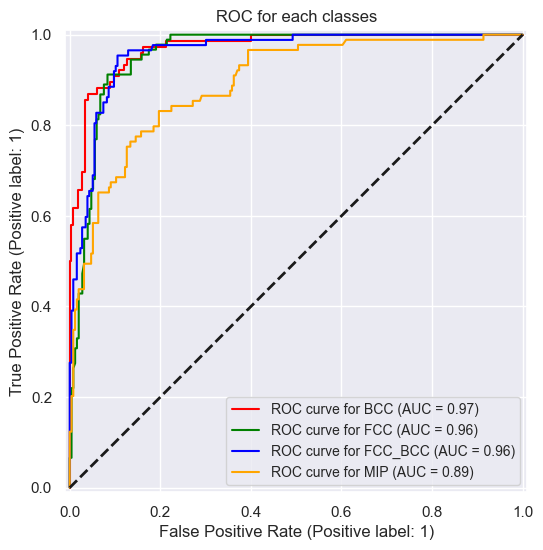

In [18]:
# PLOT ROC CURVE
fig, ax = plt.subplots(figsize=(6, 6))
y_test_oh = to_categorical(y_test)
colors = cycle(["red", "green", "blue", "orange"])
for class_id, color in zip(range(4), colors):
    RocCurveDisplay.from_predictions(
        y_test_oh[:, class_id],
        pred_proba[:, class_id],
        name=f"ROC curve for {labels[class_id]}",
        color=color,
        ax=ax,
    )
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.legend(loc='lower right', fontsize='10')
plt.title("ROC for each classes")
plt.savefig(pwd+"/figures/et_roc_curve.png", dpi=600, bbox_inches="tight")

Training accuracy per class: [0.79261364 0.80712166 0.94721408 0.78761062]
Testing accuracy per class: [0.78947368 0.72527473 0.94252874 0.6741573 ]


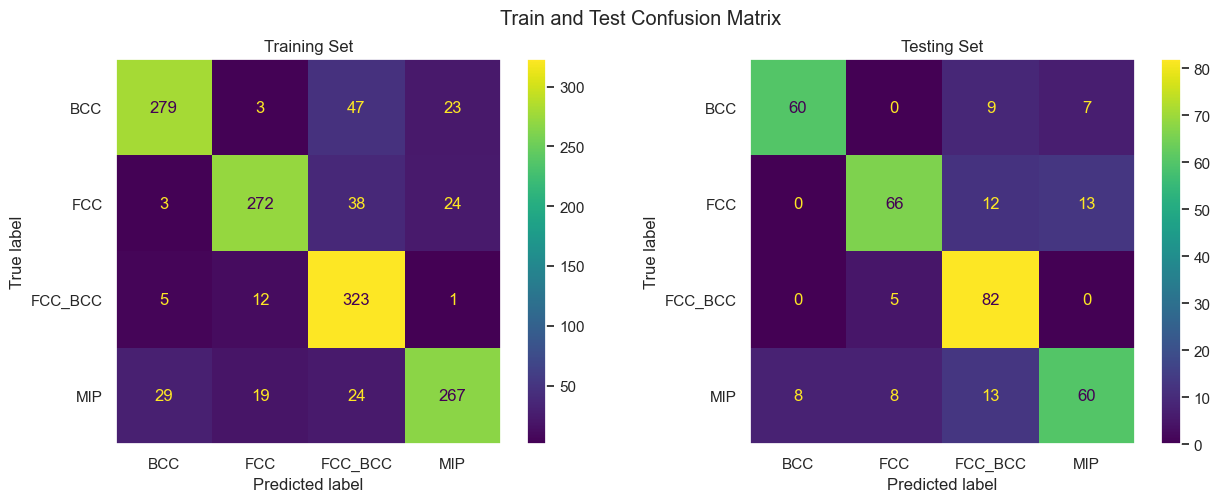

In [19]:
# CONFUSION MATRIX
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
f,(ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
disp_train.plot(ax = ax1)
disp_test.plot(ax = ax2)
ax1.set_title('Training Set')
ax2.set_title('Testing Set')
ax1.grid(False)
ax2.grid(False)
plt.suptitle('Train and Test Confusion Matrix')
plt.savefig(pwd+"/figures/et_cf.png", dpi=600, bbox_inches="tight")
# ACCURACY PER CLASS
acc_class_train = cm_train.diagonal() / cm_train.sum(axis=1)
acc_class_test = cm_test.diagonal() / cm_test.sum(axis=1)

print("Training accuracy per class:", acc_class_train)
print("Testing accuracy per class:", acc_class_test)

In [20]:
# 10 FOLD CROSS VALIDATION
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = []

for train_idx, test_idx in kfold.split(X, y):
    X_train_cv, y_train_cv = X.iloc[train_idx], y[train_idx]
    X_test_cv, y_test_cv = X.iloc[test_idx], y[test_idx]
    best_model.fit(X_train_cv, y_train_cv)
    y_test_pred_cv = best_model.predict(X_test_cv)
    score = accuracy_score(y_test_cv, y_test_pred_cv)
    cv_scores.append(score*100)

print("Cross Validation Score")
print("-"*50)
print(f"Mean Accuracy: {np.mean(cv_scores): .3f} % \nStandard Deviation: (+/-){np.std(cv_scores): .3f} %")
print("-"*50)

Cross Validation Score
--------------------------------------------------
Mean Accuracy:  79.904 % 
Standard Deviation: (+/-) 3.055 %
--------------------------------------------------
